# Levers as features


# I want a simple model where

We will be simulating the following DGPs

$$
L = 
\begin{cases}
L_l &\text{if}& \alpha_0 + \alpha_1 W + \eta < 0 \\
L_h &\text{if}& \alpha_0 + \alpha_1 W + \eta \geq 0 \\
\end{cases}
$$

$$
Y = \beta_0 + \beta_1 L + \beta_2 W  + \epsilon
$$


These are fairly simple and complex at the same time:

1. If $f=0$ there's no selection bias, so our estimates would be causal.
2. Since there's one variable in the selection process ($W$,$I$) we can quantify the impact of observing none ($X = []$), only one ($X = [W]$) and the two $(X=[W,I])$
2. $I$ is an _instrumental variable_: we want to quantify the impact on prediction performance when we observe this exogenous source of variation, and one or two of the other features.

In [132]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")



In [133]:
def create_dict_dgp(cons_lev=0, s_lev_w=1, delta_lev=2, var_lev=1,
                    cons_out=1, s_out_l=1, s_out_w=1, s_out_lw=0,var_out=1,
                    var_w=1):
    """
    This functiona allows me to make quick changes from a baseline where every parameter is one.
    Exception: is interaction term between L and W in outcome DGP, which is set to zero
    
    """
    dgp_lever = {'constant': cons_lev,
                    'slope_w' : s_lev_w,
                    'delta_lever': delta_lev,
                    'var_noise':var_lev}
    dgp_outcome = {'constant': cons_out,
                        'slope_l' : s_out_l,
                        'slope_w' : s_out_w,
                        'slope_lw' : s_out_lw,
                        'var_noise':var_out}
    dgp_exo = {'var_noise_w':var_w}
    dgp = {'lever':dgp_lever, 'outcome':dgp_outcome, 'exo':dgp_exo}
    return dgp

dgp_test = create_dict_dgp()
dgp_test_var0 = create_dict_dgp(var_lev=0, var_out=0, var_w=0)
dgp_test_var0

{'lever': {'constant': 0, 'slope_w': 1, 'delta_lever': 2, 'var_noise': 0},
 'outcome': {'constant': 1,
  'slope_l': 1,
  'slope_w': 1,
  'slope_lw': 0,
  'var_noise': 0},
 'exo': {'var_noise_w': 0}}

In [134]:
def simulate_linear_model(dgp:dict, nobs:int,seed:int, is_binary=True, print_snr=False):
  """
    Simulate DGPS with linear outcome and binary lever
  """
  np.random.seed(seed)
  # get parameters
  cons_l, lev_slope_w = dgp['lever']['constant'], dgp['lever']['slope_w']
  cons_y, out_slope_l, out_slope_w, out_slope_lw = dgp['outcome']['constant'], dgp['outcome']['slope_l'], \
                                                   dgp['outcome']['slope_w'], dgp['outcome']['slope_lw']
  var_w = dgp['exo']['var_noise_w']
  var_lev = dgp['lever']['var_noise']
  var_out = dgp['outcome']['var_noise']
  lev_l = min(0, dgp['lever']['delta_lever'])
  lev_h = max(0, dgp['lever']['delta_lever'])
  # draw noise and exogenous variables
  noise_lev = np.sqrt(var_lev) * np.random.randn(nobs)
  noise_out = np.sqrt(var_out) * np.random.randn(nobs)
  W = np.sqrt(var_w) * np.random.randn(nobs)

  # Lever: binary or continuous
  preL = cons_l + lev_slope_w*W + noise_lev 
  if is_binary:
    L = np.array([lev_l if preL[i] < 0 else lev_h for i in range(nobs)])  
    Ldum = 1*(L==lev_h)

  else:
    L = preL
    Ldum = L
  # outcome dgp
  Y = cons_y + out_slope_l*L + out_slope_w*W + out_slope_lw*L*W + noise_out
  # concatenate l and w: lever is first column
  X = np.column_stack((Ldum, W))  # (l, w)
  if print_snr:
    snr_l = np.var(L)/np.var(noise_out)
    snr_w = np.var(W)/np.var(noise_out)
    print(f'SNR(l) = {snr_l.round(3)}')
    print(f'SNR(w) = {snr_w.round(3)}')
  return Y, X

In [135]:
# test model with binary lever
# with no variance: y = 1 + 1*L + 1*0 + 0
# Since L = 2*I(1 * 1*0 + 1*0 >=0)
# Then: y = 3
y_test, x_test = simulate_linear_model(dgp=dgp_test_var0, nobs=5, seed=1)
assert np.all(y_test == 3)

In [136]:
# with selection bias: SNR(l)>SNR(w) because of the extra variance of W
# The choice of delta_lever = 2 ensures that the signal to noise of L and W are the same on average
dgp_test = create_dict_dgp()
y_test, x_test = simulate_linear_model(dgp=dgp_test, nobs=1000, seed=18, print_snr=True, is_binary=True)

SNR(l) = 1.01
SNR(w) = 1.034


In [137]:
# without SB: by design everything is symmetrical
dgp_test = create_dict_dgp(s_lev_w=0)
y_test, x_test = simulate_linear_model(dgp=dgp_test, nobs=10000, seed=18, print_snr=True, is_binary=True)

SNR(l) = 0.998
SNR(w) = 0.984


In [138]:
def evaluate_outcome(dgp:dict, X:np.array):
  "Evaluate outcome given true dgp and just x, i.e. no error.  This is like fhat(x), where fhat = true_dgp"
  cons_y, out_slope_l, out_slope_w, out_slope_lw= dgp['outcome']['constant'],  \
                    dgp['outcome']['slope_l'], dgp['outcome']['slope_w'], dgp['outcome']['slope_lw']
  # Order is # (l, w,i)
  nobs, nvar = X.shape
  # initialize L,W to arrays of zeros
  L = np.zeros(nobs)
  W = np.zeros(nobs)
  if nvar == 1:  # when we "omit" W we only
    L = X[:,0]
  elif nvar > 1:
    L = X[:,0]
    W = X[:,1]

  Y = cons_y + out_slope_l*L + out_slope_w*W + out_slope_lw * L * W
  return Y


In [139]:
def optimize_lever(fhat,x,dgp):
    """
    Get optimal lever per unit, by finding Lopt = argmax(yhat := fhat(x))
    When fhat is true_dgp: we get the ground truth
    But other times we're interested in using fhat = model.predict()
    Returns: optimal lever at the unit level
    """
    nobs = x.shape[0]
    l_low, l_high = 0, 0 + dgp['lever']['delta_lever']
    #initialize y_arr of size nobs,2
    y_arr = np.zeros((nobs,2))
    x_simu = x.copy()
    for l,lev in enumerate([l_low, l_high]):
        # asign lever --> x for all units and evaluate with fhat
        x_simu[:,0] = lev
        y_arr[:,l] = fhat(x_simu)
    # find optimal lever
    l_opt_ix = np.argmax(y_arr, axis=1)
    l_opt = np.array([l_low if l_opt_ix[i]==0 else l_high for i in range(nobs)])
    return l_opt

In [16]:
def train_eval_model(y,x,dgp,seed=1, model = RandomForestRegressor, is_optimize=True, **kwargs):
    """
    High-level overview:
    1. Train model and save fhat = model.predict()
    2. Optimize lever given fhat
    3. Optimize lever given true_dgp
    4. Measure performance
    5. Run linear regression to get the coeficients to check omitted variable bias
    """
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=seed)
    # Linear regression: to check OVB
    X_train1 = sm.add_constant(X_train)
    model_lr = sm.OLS(y_train, X_train1).fit()
    ols_coefs = model_lr.params[1:]
    dict_ols = {}
    dict_ols['ols_coefs'] = ols_coefs
    # Now performance metrics given model
    md = model(**kwargs)
    md.fit(X_train, y_train)
    y_pred = md.predict(X_test)
    mse = np.mean((y_test - y_pred)**2)
    r2 = r2_score(y_test, y_pred)
    dict_results = {'mse':mse, 
                    'r2_score':r2}
    if is_optimize:
        # Now optimize the lever under fhat
        lev_opt = optimize_lever(fhat=md.predict,x=X_test,dgp=dgp)
        y_opt_test = evaluate_outcome(dgp, np.column_stack((lev_opt, X_test[:,1:])))
        # Check against ground truth (i.e. with true DGP)
        lev_true_dgp = optimize_lever(fhat=lambda x: evaluate_outcome(dgp, x), x=X_test, dgp=dgp)
        y_opt_true = evaluate_outcome(dgp, np.column_stack((lev_true_dgp, X_test[:,1:])))
        # some statistics
        # Accuracy: fraction of times where lever was correctly chosen with learned fhat
        accuracy = np.mean(lev_opt == lev_true_dgp)
        # RMSE_opt: root mean squared error of ground truth and learned optimal
        rmse_opt = np.sqrt(np.mean((y_opt_test - y_opt_true)**2))
        # Delta y: How much money did we loose by optimizing with the learned fhat
        delta_y = np.sum(y_opt_test - y_opt_true)
        dict_results['accuracy'] = accuracy
        dict_results['rmse_opt'] = rmse_opt
        dict_results['delta_y'] = delta_y

    return dict_results, dict_ols

In [143]:
# test function
tem_test = train_eval_model(y_test,x_test[:,[0]],dgp_test,seed=1, model = RandomForestRegressor, is_optimize=False)
tem_test[1]['ols_coefs'][0]

2.06181620215847

In [160]:
def compute_quantiles(arr_k:np.array, cols:list=None, p_low:float=0.05, p_high:float=0.95):
  """
  Compute quantiles of the results
  """
  nrows, ncols = arr_k.shape
  if cols is None:
    cols = [f'col_{i}' for i in range(ncols)]
  df_res = pd.DataFrame(np.mean(arr_k, axis=0).reshape(1,ncols), columns=cols, index=['mean'])
  df_res.loc['q_low'] = np.quantile(arr_k, p_low, axis=0)
  df_res.loc['q_high'] = np.quantile(arr_k, p_high, axis=0)

  return df_res

In [173]:
def run_montecarlo(seed_mc:int, num_montecarlo:int, nobs:int, dgp:dict, is_optimize=True, is_binary=False, model=RandomForestRegressor):
  """
  MC simulation to estimate impact on MSE and R2 of different models
  """
  np.random.seed(seed_mc)
  seed_arr = np.random.randint(low=1, high=10000, size=num_montecarlo, dtype=int)
  # initilize containers
  ols_arr0 = np.full((num_montecarlo, 2), np.nan)
  ols_arr1 = np.full((num_montecarlo, 2), np.nan)
  ols_arr2 = np.full((num_montecarlo, 2), np.nan)
  dict_results = {}
  mse_arr = np.zeros((num_montecarlo, 3))
  r2_arr = np.zeros((num_montecarlo, 3))
  if is_optimize:
    acc_arr = np.zeros((num_montecarlo, 3))
    rmse_opt_arr = np.zeros((num_montecarlo, 3))
    delta_y_arr = np.zeros((num_montecarlo, 3))

  for i in range(num_montecarlo):
    # Simulate models
    out_i, X_i = simulate_linear_model(dgp, nobs, seed=seed_arr[i], is_binary=is_binary)
    # In what follows: Remember that: X = (l, w)
    # Base Case: X = (l,w) --> We observe everything that matters foor output (l,w)
    X0 = X_i[:,[0,1]]
    dict0, dict_ols0 = train_eval_model(out_i, X0, dgp, is_optimize, model)
    ols_arr0[i,:] = dict_ols0['ols_coefs']
    # Case 1: X = (l) - Exclude w: violate selection on observables
    X1 = X_i[:,[0]]
    dict1, dict_ols1 = train_eval_model(out_i, X1, dgp, is_optimize, model)
    ols_arr1[i,0] = dict_ols1['ols_coefs'][0]
    # Case 2: X = (w) - Exclude w: violate selection on observables
    X2 = X_i[:,[1]]
    dict2, dict_ols2 = train_eval_model(out_i, X2, dgp, is_optimize, model)
    ols_arr2[i,1] = dict_ols2['ols_coefs'][0]
    # organize everything
    if len(dict0.values())==5:
      m0,r0, a0, mo0, dy0 = dict0.values()
      m1,r1, a1, mo1, dy1  = dict1.values()
      m2,r2, a2, mo2, dy2  = dict2.values()
    elif len(dict0.values())==2:
      m0,r0 = dict0.values()
      m1,r1  = dict1.values()
      m2,r2  = dict2.values()
      a0, a1, a2 = np.nan,np.nan,np.nan
      mo0, mo1, mo2 = np.nan,np.nan,np.nan
      dy0, dy1, dy2 = np.nan,np.nan,np.nan
    # assemble results
    mse_arr[i,:] = [m0, m1, m2]
    r2_arr[i,:] = [r0, r1, r2]
    acc_arr[i,:] = [a0, a1, a2]
    rmse_opt_arr[i,:] = [mo0, mo1,mo2]
    delta_y_arr[i,:] = [dy0, dy1, dy2]
  
  # save as dicts
  dict_results['mse'] = mse_arr
  dict_results['r2'] = r2_arr
  if is_optimize: 
    dict_results['accuracy'] = acc_arr
    dict_results['rmse_opt'] = rmse_opt_arr
    dict_results['delta_y'] = delta_y_arr
  # Compute mean and qlow, q_high for ols coefficients
  dict_ols = {}
  col_lab = ['M0: X = (L,W)', 'M1: X = (L)', 'M2: X = (W)']
  cols_ols = ['l','w']
  for c, arr_c in enumerate([ols_arr0,ols_arr1,ols_arr2]):
    dict_ols[col_lab[c]] = compute_quantiles(arr_c, cols=cols_ols, p_low=0.05, p_high=0.95)
  # finally compute mean and q05, q95 for each of these arrays
  dict_stats = {}
  for key in dict_results.keys():
    dict_stats[key] = compute_quantiles(dict_results[key], cols=col_lab, p_low=0.05, p_high=0.95)

  return dict_stats, dict_results, dict_ols


In [174]:
def plot_results(df_res:pd.DataFrame, ax:plt.Axes, title = None, **kwargs):
  """ 
  given a dataframe with mean and quantiles, plot the results with error bars
  """
  df = df_res.T
  # to use yerr: I need the length of the bars: mean-low, high-mean
  yerr = np.array([df_res.loc['mean'] - df_res.loc['q_low'], df_res.loc['q_high'] - df_res.loc['mean']])
  yerr[yerr<0] = 0  # length of error bars can never be negative
  df.plot(kind='bar', ax=ax, y='mean', yerr=yerr, capsize=5, **kwargs)
  ax.set_xticklabels(df.index, rotation=90)
  ax.set_title(title)

  return ax

In [175]:
# Test functions with only MC simulation
nobs = 1000
seed_mc = 1
num_montecarlo = 5
# dgps with and without selection bias
dgp_sb = create_dict_dgp(s_lev_w=1)
dgp_r = create_dict_dgp(s_lev_w=0)  # random selection has slope for w = 0 <-- W doesn't affect L, so no selection bias
dict_stats_sb, a, dict_ols_sb= run_montecarlo(seed_mc, num_montecarlo, nobs, dgp_sb)
dict_stats_r, b, dict_ols_sb = run_montecarlo(seed_mc, num_montecarlo, nobs, dgp_r)
dict_ols_sb

{'M0: X = (L,W)':                l         w
 mean    1.010205  1.007677
 q_low   0.966514  0.948186
 q_high  1.032786  1.069871,
 'M1: X = (L)':                l   w
 mean    0.981306 NaN
 q_low   0.906838 NaN
 q_high  1.037367 NaN,
 'M2: X = (W)':          l         w
 mean   NaN  0.980610
 q_low  NaN  0.903728
 q_high NaN  1.029936}

# Task 1: You only care about prediction

#### Should you include the lever?

Simulate under three scenarios:
* Positive selection
* Negative selection
* No selection


In [397]:
def plot_ols_results(dict_results, labs_simu):
    results_ols = dict_results['ols']
    ncols = len(labs_simu)
    labs_comb = [f'{simu} - {feat}' for simu in ['M0', 'M1', 'M2'] for feat in ['L','W']]
    fig, ax = plt.subplots(1, ncols, figsize=(6*ncols, 4))
    if ncols>1:
        labs = labs_simu
    elif ncols==1:
        labs = ['SNR']
    for j, (dict_k, simu_lab) in enumerate(zip(results_ols, labs)):
        ax_j = ax[j] if ncols>1 else ax
        # first iterate over the three models and concatenate horizontally
        for s,simu in enumerate(['M0: X = (L,W)', 'M1: X = (L)', 'M2: X = (W)']):
            if s==0:
                df_s = dict_k[2][simu]
            else:
                df_s = pd.concat([df_s,dict_k[2][simu]], axis=1)
        df_s.columns = labs_comb      
        # drop columns with NaNs
        df_s = df_s.dropna(axis=1)
        ax_j = plot_results(df_s, title=f'OLS coefficients: {simu_lab}', ax=ax_j)
        ax_j.legend().set_visible(False)
        # include a horizontal line at 0
        ax_j.axhline(y=0, color='black', linestyle='-')
    fig.tight_layout()
    return None

def plot_metric_results(dict_results, labs_simu, metric = 'mse'):
    nrows = len(dict_results.keys())
    ncols = len(labs_simu)
    metric_str = metric.upper()
    if ncols > 1:
        labs = labs_simu
    else:
        labs = ['SNR']
        nrows, ncols = ncols, nrows
    fig, ax = plt.subplots(nrows, ncols, figsize=(18, nrows*3))
    for i, meth in enumerate(dict_results.keys()):
        for j, (dict_k, simu_lab) in enumerate(zip(dict_results[meth], labs)):
            ax_ij = ax[i,j] if nrows>1 else ax[j]
            simu_lab = meth if ncols==1 else simu_lab
            plot_results(dict_k[0][metric], ax_ij, title=f'{metric_str}: {simu_lab}')
            ax_ij.set_xticklabels(['M0: X = (L,W)', 'M1: X = (L)', 'M2: X = (W)'], rotation=0)
            ax_ij.legend().set_visible(False)
            if j ==0:
                ax_ij.set_ylabel(meth)
    fig.tight_layout()



In [328]:
nobs = 500
seed_mc = 1
num_montecarlo = 150
slope_lever_w = 1
dgp_positive = create_dict_dgp(s_lev_w=slope_lever_w)
dgp_negative = create_dict_dgp(s_lev_w=-slope_lever_w)
dgp_zero = create_dict_dgp(s_lev_w=0)
labs_simu = ['Positive', 'Negative', 'Random']
for d, dgpish in enumerate([dgp_positive, dgp_negative, dgp_zero]):
    dgp_dl = dgpish['lever']
    dgp_do = dgpish['outcome']
    print('-'*20 + labs_simu[d] + '-'*20)
    print(f'DGP lever ({labs_simu[d]} Selection): {dgp_dl}')
    print(f'DGP outcome ({labs_simu[d]} Selection): {dgp_do}')


--------------------Positive--------------------
DGP lever (Positive Selection): {'constant': 0, 'slope_w': 1, 'delta_lever': 2, 'var_noise': 1}
DGP outcome (Positive Selection): {'constant': 1, 'slope_l': 1, 'slope_w': 1, 'slope_lw': 0, 'var_noise': 1}
--------------------Negative--------------------
DGP lever (Negative Selection): {'constant': 0, 'slope_w': -1, 'delta_lever': 2, 'var_noise': 1}
DGP outcome (Negative Selection): {'constant': 1, 'slope_l': 1, 'slope_w': 1, 'slope_lw': 0, 'var_noise': 1}
--------------------Random--------------------
DGP lever (Random Selection): {'constant': 0, 'slope_w': 0, 'delta_lever': 2, 'var_noise': 1}
DGP outcome (Random Selection): {'constant': 1, 'slope_l': 1, 'slope_w': 1, 'slope_lw': 0, 'var_noise': 1}


In [329]:
# run with three models:
methods = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor]
labs_meth = ['ols', 'rf', 'gb']
dict_results = {}
for m, meth in enumerate(methods):
    mc_pos = run_montecarlo(seed_mc, num_montecarlo, nobs, dgp_positive, model=meth)
    mc_neg = run_montecarlo(seed_mc, num_montecarlo, nobs, dgp_negative, model=meth)
    mc_rnd = run_montecarlo(seed_mc, num_montecarlo, nobs, dgp_zero, model=meth)
    dict_results[labs_meth[m]] = [mc_pos, mc_neg, mc_rnd]

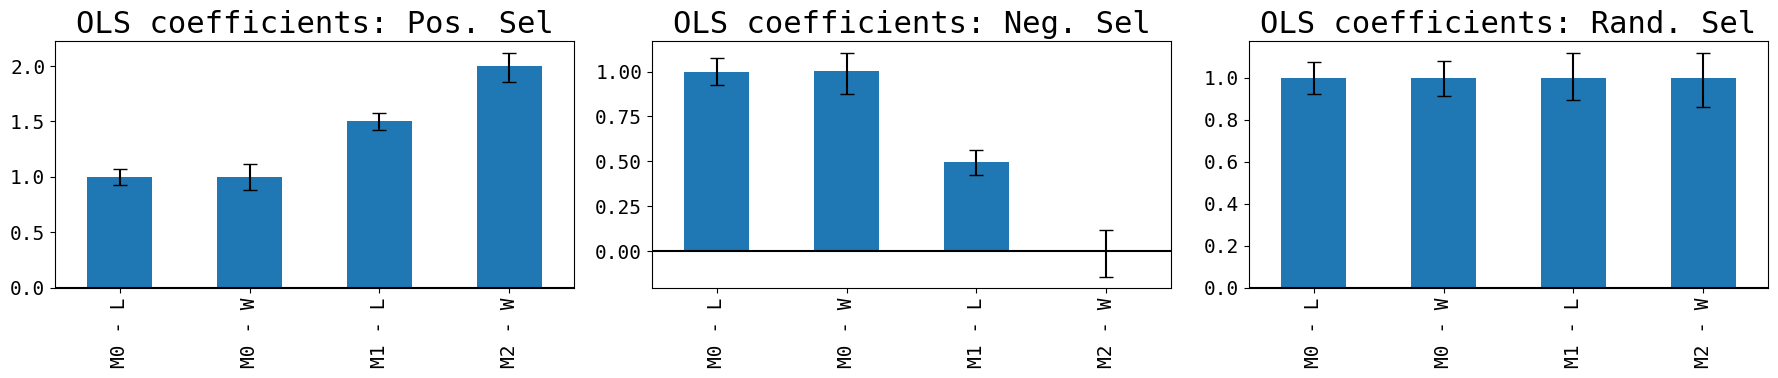

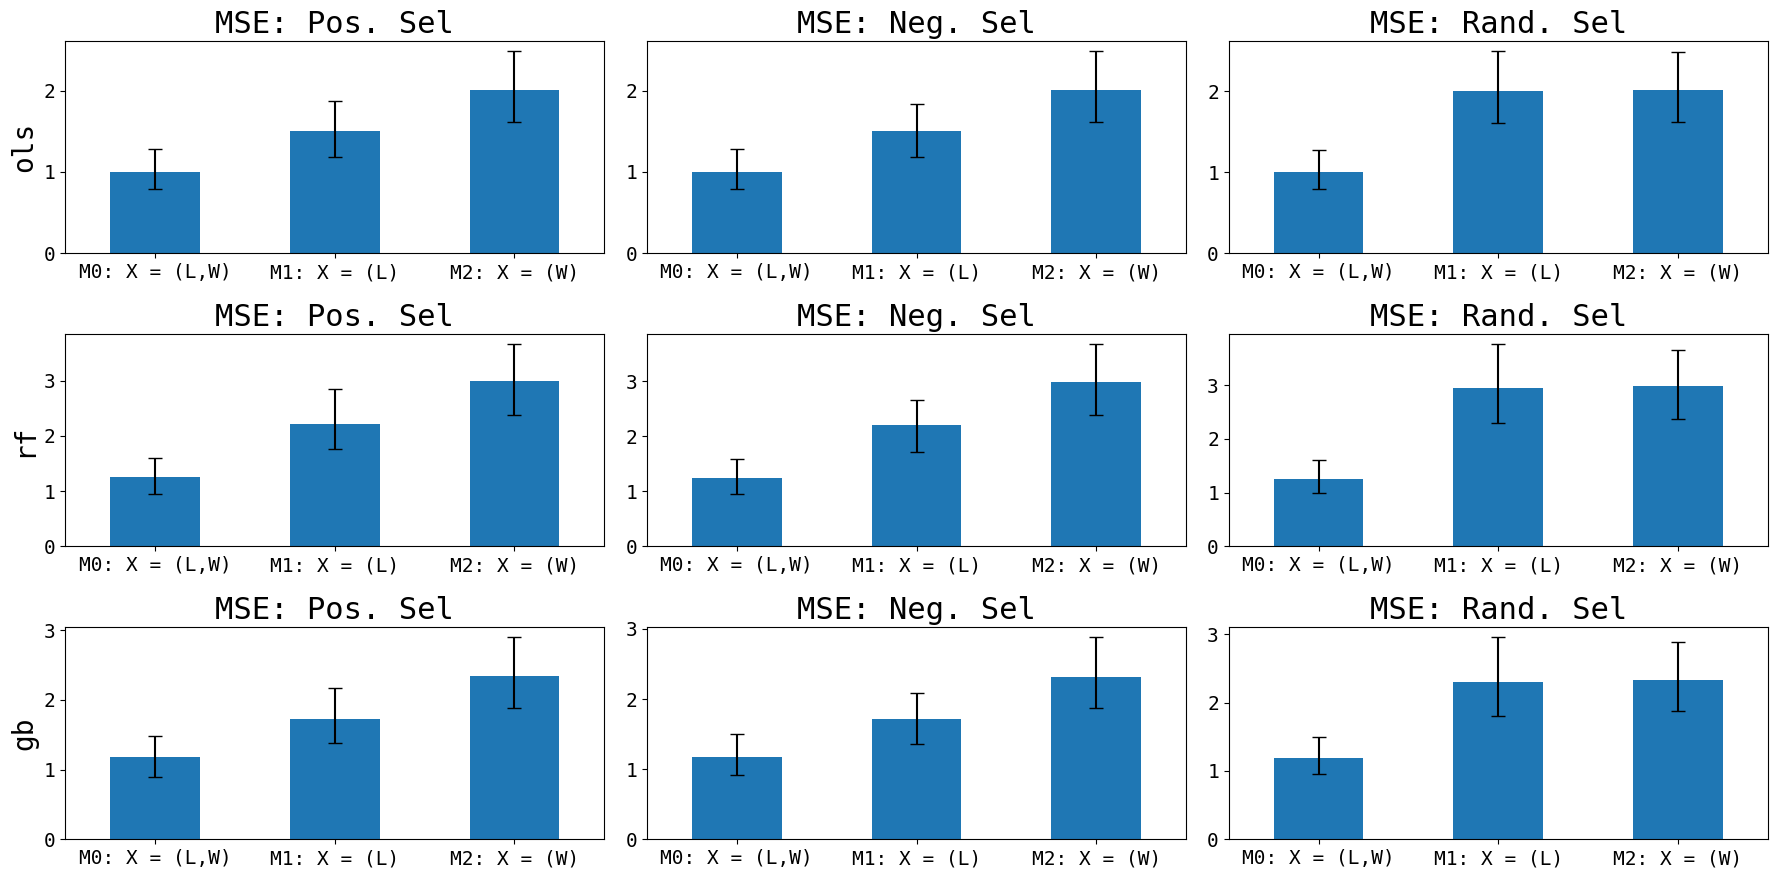

In [398]:
labs_simu = ['Pos. Sel', 'Neg. Sel', 'Rand. Sel']
plot_ols_results(dict_results, labs_simu = labs_simu)
plot_metric_results(dict_results, labs_simu = labs_simu)

## Recall that OVB:
Assume a linear lever (in a binary context the same logic applies but the equations get messier)
$$
y = \beta_0 + \beta_1 l + \beta_2 x + \epsilon
$$

$$
l = \alpha_0 + \alpha_1 x + \eta
$$

If I omit $x$ from the regression for the outcome, the OVB equation shows that:

$$
\hat{\beta}_1 = \beta_1 + \frac{Cov(x,l)}{Var(l)} = \beta_1 + \frac{\alpha_1 Var(x)}{Var(l)} = \beta_1 + \alpha_1 \times SNR(x,l)
$$

## Now, let's do two things:

1. Increase SNR for $w$ in the selection equation
2. Change the coefficient of l from 1 to -0.5

In [401]:
# to increase the SNR of the lever, I can increase the variance of W and reduce the variance of eta
nobs = 500
seed_mc = 1
num_montecarlo = 150
var_w = 10
var_lev = 0.1
delta_lev = 2
s_lev_w = -0.5 # this corresponds to alpha1 in the formula... by having negative selection and high SNR, I can change the sign of the coefficient
dgp_snr = create_dict_dgp(var_w=var_w, var_lev=var_lev, delta_lev=delta_lev, s_lev_w=s_lev_w)
dgp_rnd = create_dict_dgp(var_w=var_w, var_lev=var_lev, delta_lev=delta_lev, s_lev_w=0)
for i, dgpi in enumerate([dgp_snr, dgp_rnd]):
    labi = 'SNR' if i==0 else 'RND'
    dgp_lever = dgpi['lever']
    dgp_outcome = dgpi['outcome']
    print('-'*50)
    print(f'{labi}: DGP Lever: {dgp_lever}')
    print(f'{labi}: DGP Outcome: {dgp_outcome}')

dict_results_snr = {}
for m, meth in enumerate(methods):
    mc_snr = run_montecarlo(seed_mc, num_montecarlo, nobs, dgp_snr, model=meth)
    mc_rnd = run_montecarlo(seed_mc, num_montecarlo, nobs, dgp_rnd, model=meth)
    dict_results_snr[labs_meth[m]] = [mc_snr, mc_rnd]

--------------------------------------------------
SNR: DGP Lever: {'constant': 0, 'slope_w': -0.5, 'delta_lever': 2, 'var_noise': 0.1}
SNR: DGP Outcome: {'constant': 1, 'slope_l': 1, 'slope_w': 1, 'slope_lw': 0, 'var_noise': 1}
--------------------------------------------------
RND: DGP Lever: {'constant': 0, 'slope_w': 0, 'delta_lever': 2, 'var_noise': 0.1}
RND: DGP Outcome: {'constant': 1, 'slope_l': 1, 'slope_w': 1, 'slope_lw': 0, 'var_noise': 1}


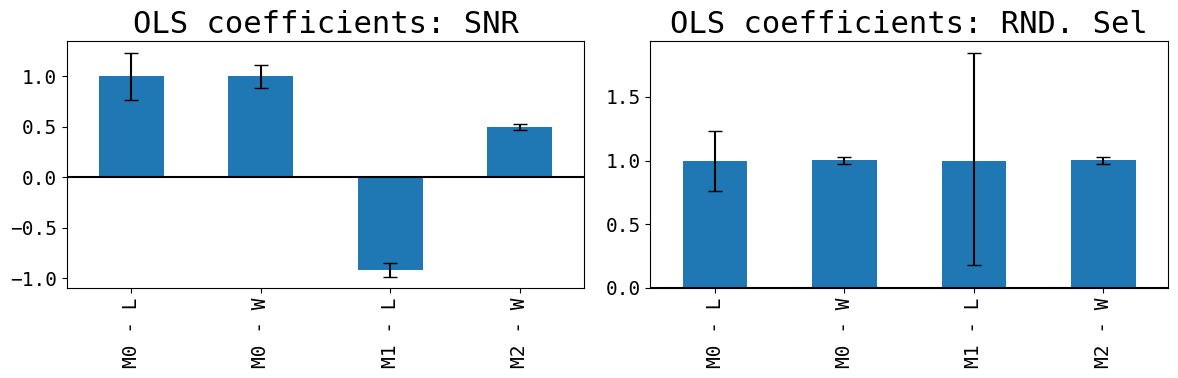

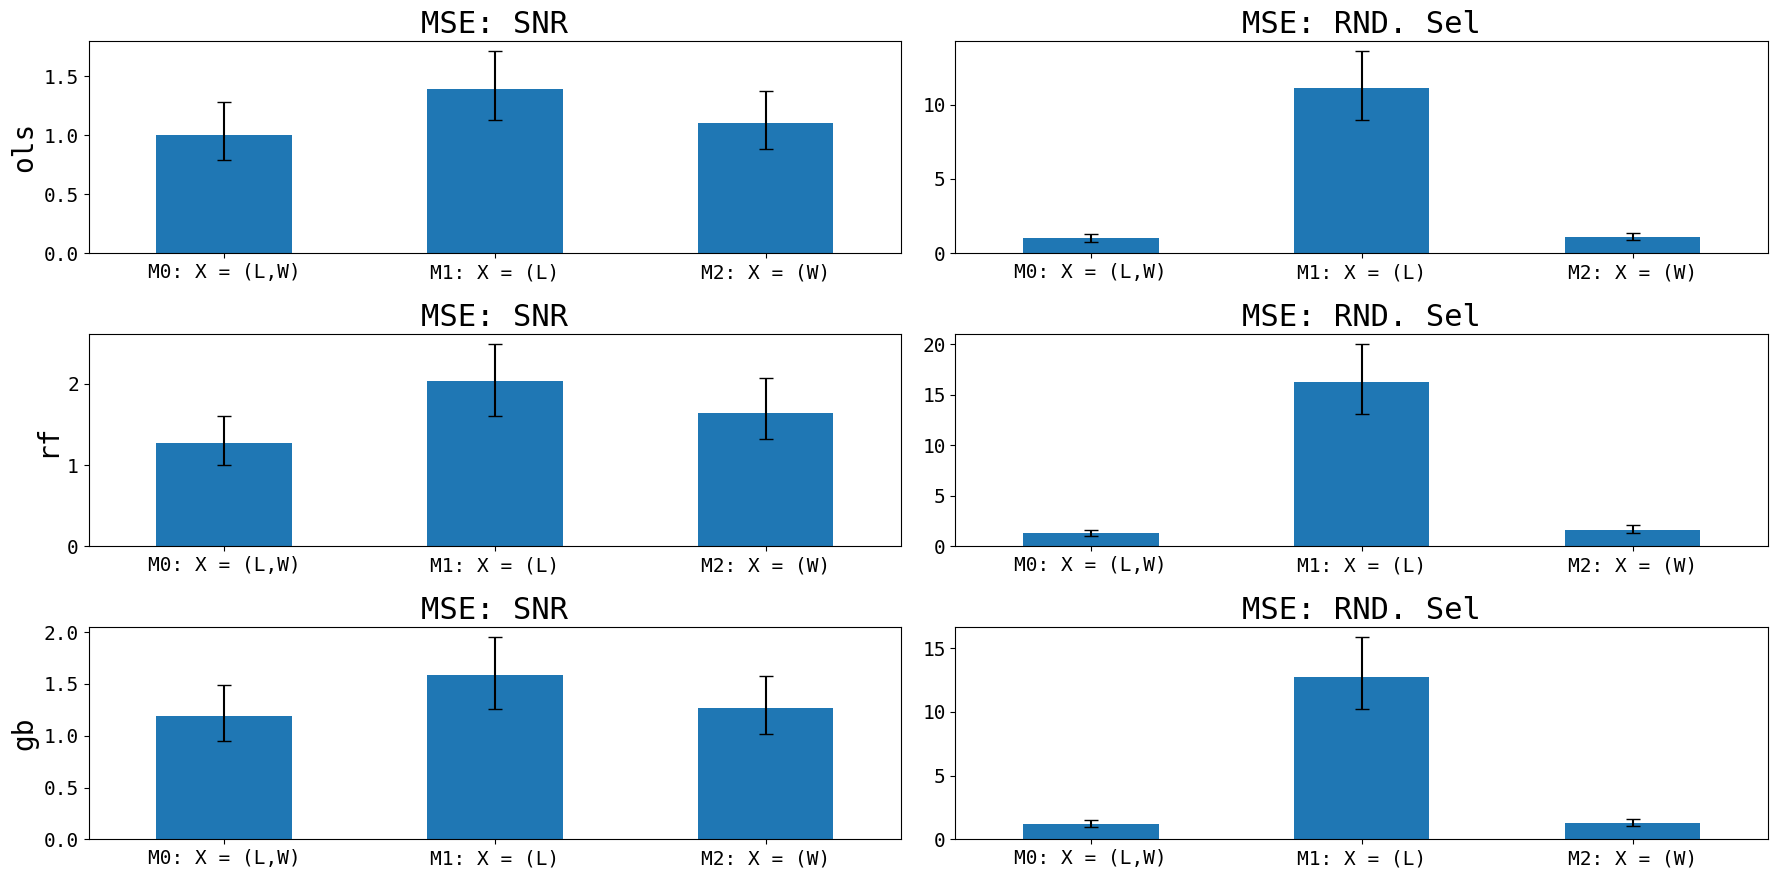

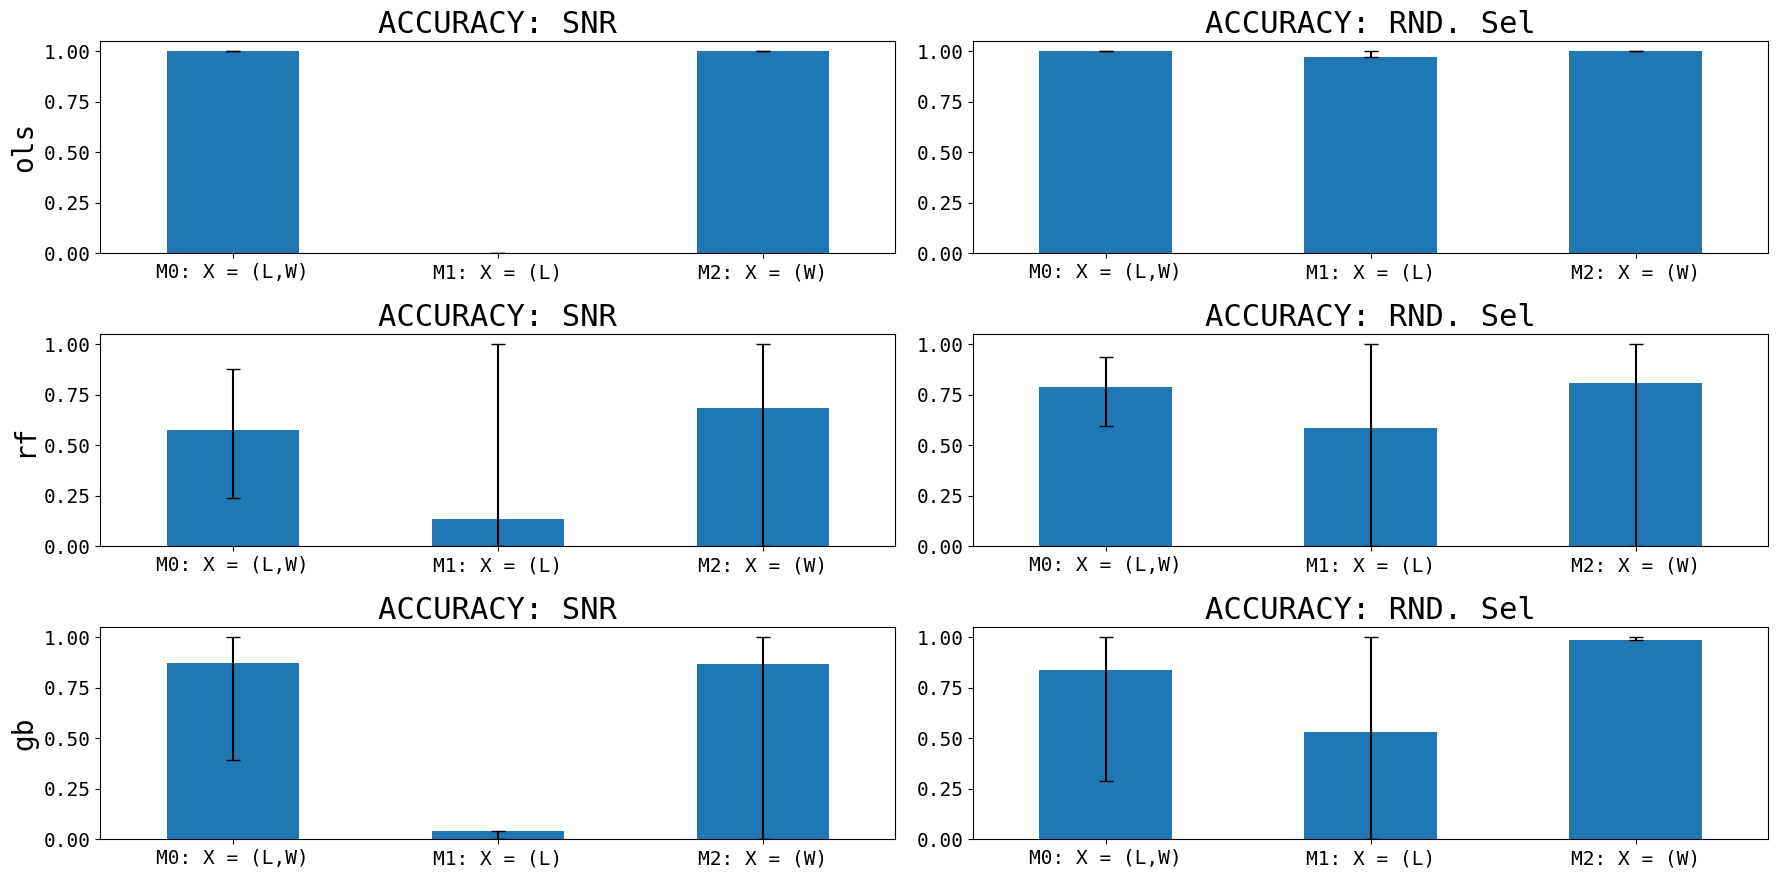

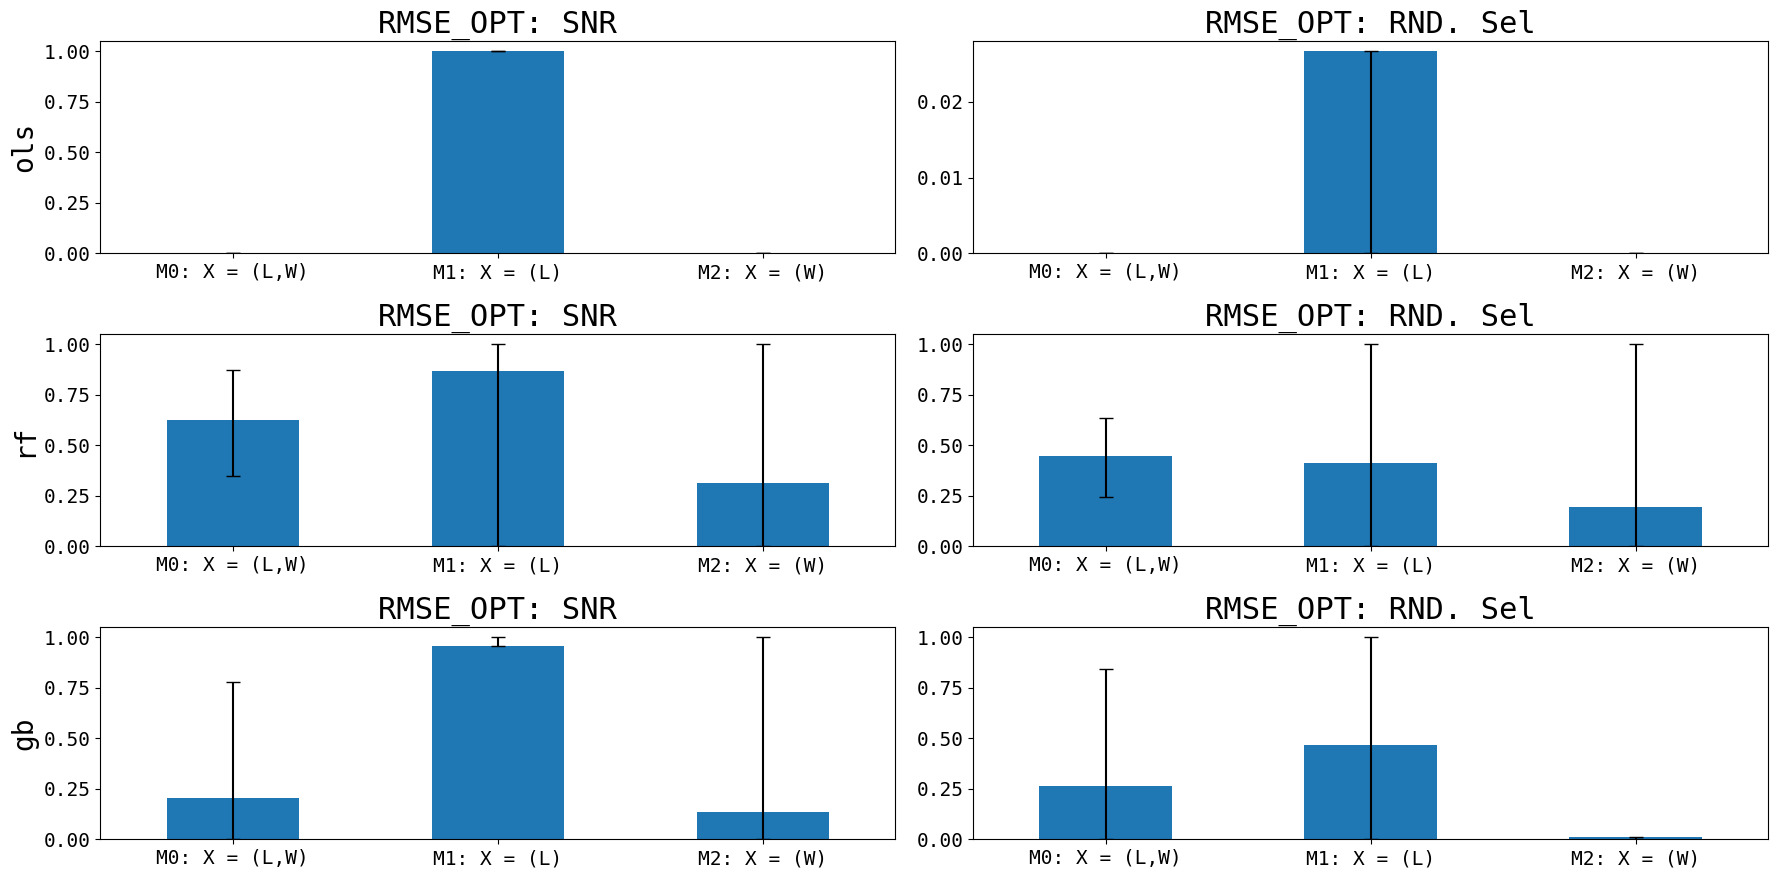

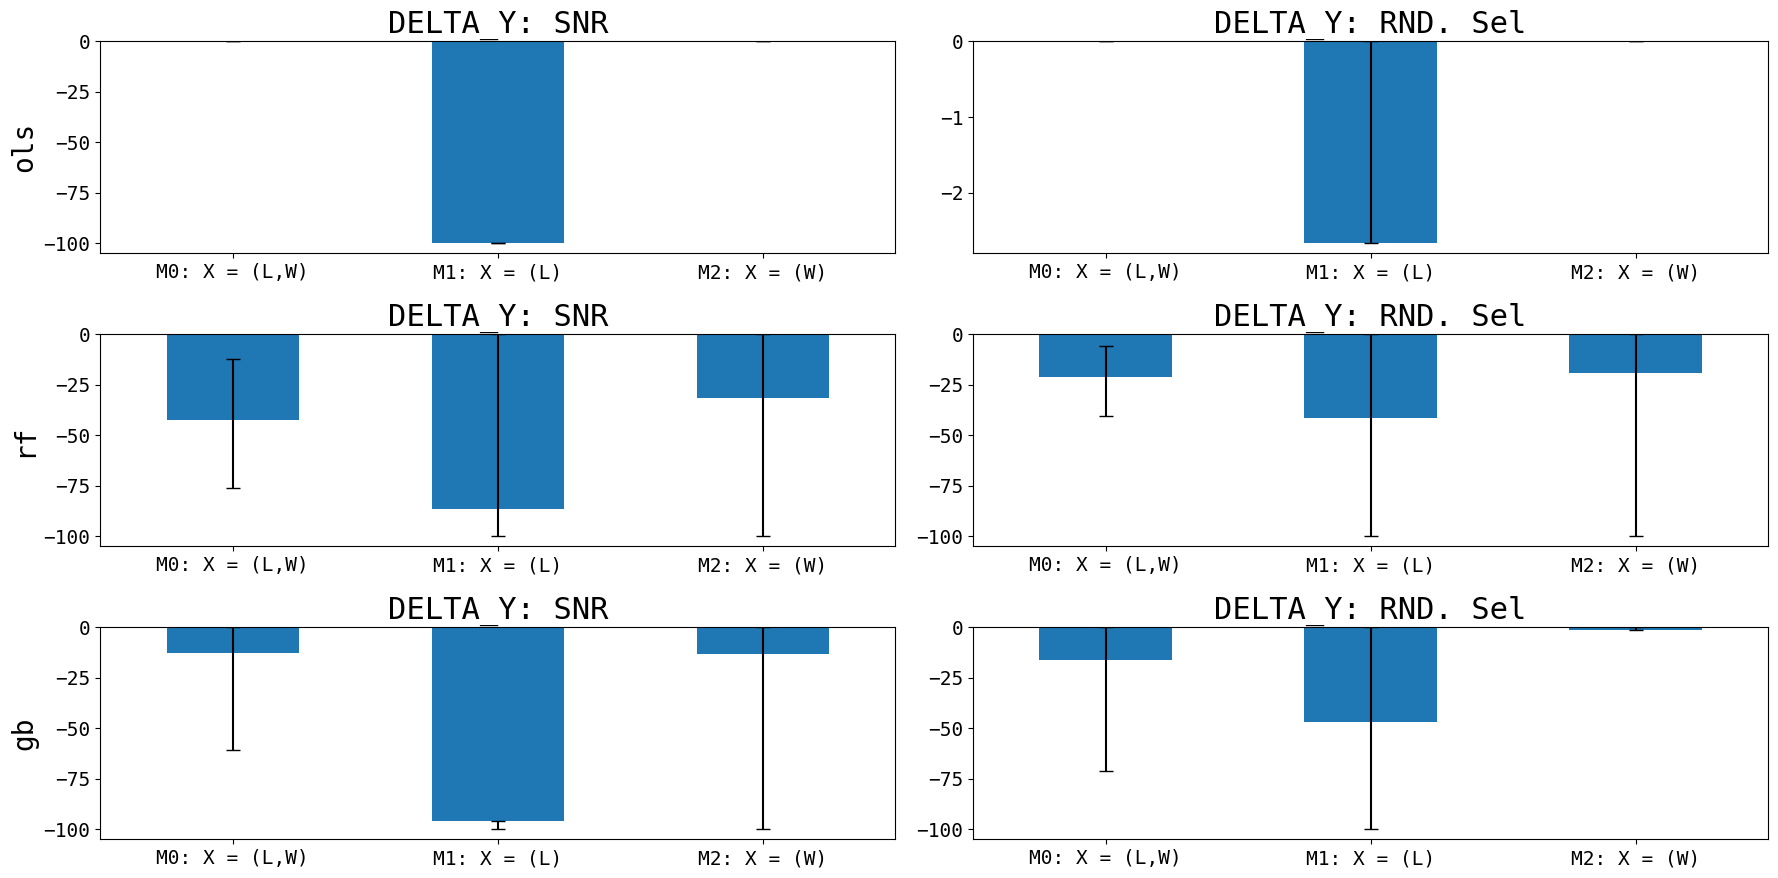

In [ ]:
# let's plot the relevant results
labs_simu = ['SNR', 'RND. Sel']
plot_ols_results(dict_results_snr, labs_simu)
plot_metric_results(dict_results_snr, labs_simu)
plot_metric_results(dict_results_snr, labs_simu, metric='accuracy')
plot_metric_results(dict_results_snr, labs_simu, metric='rmse_opt')
plot_metric_results(dict_results_snr, labs_simu, metric='delta_y')


# Omitted Variable Bias with spurious correlation

* In the post I mentioned that you can have OVB even when there's no causal link between the two features.

* You can use the following code to verify this

In [394]:
# In the post I mention that OVB happens even if there's spurious correlation
# Let's simulate this case in the simplest setting
# I'm not running a montecarlo simulation, just a single case, but you can change it if you want to verify the distribution
nobs = 1000
seed = 1
coef_lw =1 # you can make this zero to see that the OVB disappears
coef_xw = 1 # you can make this zero to see that the OVB disappears
W = np.random.randn(nobs)
L = coef_lw*W + np.random.randn(nobs)
X = coef_xw*W + np.random.randn(nobs)
Y = 1*L + 1*X + np.random.randn(nobs)
Xmat = np.column_stack((L, X))
Xmat_star = L.reshape(-1,1)
# run OLS with both variables and save the coefficient for L
Xmat1 = sm.add_constant(Xmat)
model = sm.OLS(Y, Xmat1).fit()
ols_coef = model.params[1]
# now run OLS with only L
model1 = sm.OLS(Y, Xmat_star).fit()
ols_coef1 = model1.params[0]
# print both coefficients
print(f'OLS with both variables: {ols_coef}')
print(f'OLS with only L: {ols_coef1}')



OLS with both variables: 0.9645497384172141
OLS with only L: 1.461154003695823
